In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import json
pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [71]:
# Read config
with open('config.json') as json_file:
    f = json.load(json_file)
    NUMBER_OF_QUERIES = f['number_of_queries']
    REPETITIONS = f['repetitions']
    ROWS = f['rows']
    SELECTIVITIES = [f['selectivity']]
    COLS = f['cols']
    EXPS_DEFAULTS = f['experiments']
    PARTITION_SIZE = f['partition_size']
    PROGRESSIVE_INDEX_DELTAS = f['deltas']

# Algorithms and Experiments defitions
algorithms = {
    'ProgressiveIndexCostModel': {
        'name': 'progressive_index_cm',
        'color': 'purple',
        'dash': 'dot',
        'show_name': 'GPKD(.2)',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    }
}

for key, value in algorithms.items():
    name = value['name']
    delta = value['delta']
    partition_size = value['partition_size']
    algorithms[key]['alg_id'] = f"{name}-{delta}-{partition_size}"
    
# Synthetic Experiments
experiments = {}

for i in [2]:
    temp = {
        f'Uniform{i}': {
            "name": f"Unif({i})",
            'name-in-file': 'uniform',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        }
    }
    experiments = {**experiments, **temp}
    
for key, value in experiments.items():
    name = value['name-in-file']
    rows = value['n_rows']
    n_queries = value['n_queries']
    cols = value['n_cols']
    sel = value['sel']
    experiments[key]['exp_id'] = f"{name}-{rows}-{n_queries}-{cols}-{sel}"

In [72]:
# Input/Output
def read(alg, exp):
    if exp.startswith('Shifting'):
        n_queries_per_run = 10
        uni = read(alg, 'Uniform' + experiments[exp]['n_cols'])
        n_runs = int(len(uni)/n_queries_per_run) - 1
        df_final = uni.head(n_queries_per_run)
        for _ in range(int(n_runs)):
            temp = uni.head(n_queries_per_run).copy()
            df_final = df_final.append(temp, ignore_index=True)
    else:
        df = pd.read_csv(f"results/{algorithms[alg]['alg_id']}-{experiments[exp]['exp_id']}.csv")
        repetitions = df['repetition'].max() + 1
        step = int(len(df.index)/repetitions)
        df_final = df[:step].copy().reset_index()
        for rep in range(1, repetitions):
            df_final += df[step * (rep) : step * (rep + 1)].copy().reset_index()

        df_final = df_final/repetitions
    
    if 'index_search_time' not in df_final:
        df_final['index_search_time'] = 0.0
    if 'tuples_scanned' not in df_final:
        df_final['tuples_scanned'] = 0.0
    if 'number_of_nodes' not in df_final:
        df_final['number_of_nodes'] = 0.0
    df_final['query_time'] = df_final['initialization_time'] + df_final['index_search_time'] + df_final['scan_time'] + df_final['adaptation_time']
    df_final['query_time_cumsum'] = df_final['query_time'].cumsum()
    return df_final

                     
def read_multiple(algs, exp):
    ''' Reads multiple algorithms in an experiment, return three arrays: dfs, colors, names
    '''
    dfs = []
    colors = []
    names = []
    dashes = []
    for alg in algs:
        dfs.append(read(alg, exp))
        names.append(algorithms[alg]['show_name'])
        colors.append(algorithms[alg]['color'])
        dashes.append(algorithms[alg]['dash'])
    
    return dfs, colors, dashes, names,

                     
def save_figure(fig, fig_name):
    fig.write_image(f"figures/{fig_name}", width=1024, height=768)
                     
def save_table(table, table_name):
    with open(f"tables/{table_name}", 'w') as f:
        f.write(table)

In [73]:
# Figures

delta_cols = [2, 4, 5, 6, 7, 8]
delta_markers = ['circle', 'square', 'x', 'star', 'triangle-up', 'diamond']

def create_figure(data=[]):
    fig = go.Figure(
        data=data,
        layout=go.Layout(
#             width=1500,
            plot_bgcolor='rgba(0,0,0,0)',
            font=dict(
                size=42
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgrey',
                zeroline=False,
                zerolinecolor='rgba(0, 0, 0, 0)',
                ticks="inside",
                ticklen=5
            ),
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks='inside',
                zeroline=True,
                ticklen=5
            ),
            legend=dict(
                font=dict(
                    size=30,
                    color="black"
                )
            )
        )
    )
    return fig

def line(exp, alg, attrs, names, limit=2000):
    df = read(alg, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for attr, name in zip(attrs, names):
        attr_values = np.array(df[attr][:limit])
        lines.append(
            go.Scatter(
                name=name,
                x=list(range(len(attr_values))),
                y=attr_values,
                mode='lines',
                line=dict(width=4)
            )
        )
    
    fig.add_traces(data=lines)
    fig.update_layout(showlegend=True, yaxis_title=attr)
    return fig


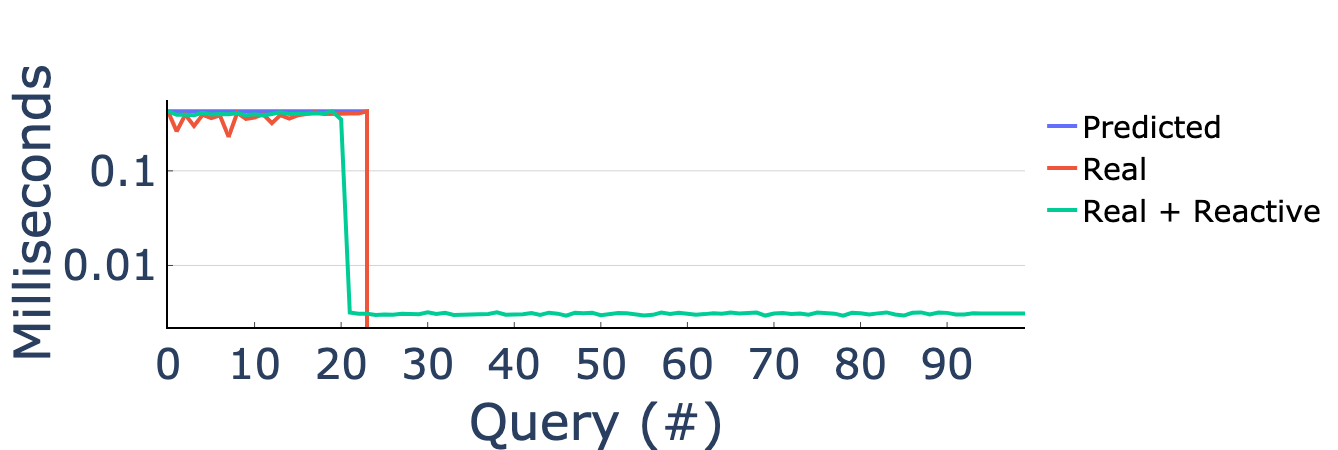

In [75]:
l = line('Uniform2', 'ProgressiveIndexCostModel', ['cm_time', 'cm_realtime', 'query_time'], ['Predicted', 'Real', 'Real + Reactive'])
l.update_layout(yaxis_title='Milliseconds', xaxis_title='Query (#)')
l.update_yaxes(type="log", tickvals=[0.01, 0.1, 10])
# save_figure(l, 'cost_model.pdf')
l

In [50]:
read('ProgressiveIndexCostModel', 'Uniform2')

,index,adaptation_time,cm_realtime,cm_time,index_search_time,initialization_time,scan_time,tuples_scanned,repetition,number_of_nodes,query_time,query_time_cumsum
0,0.0,0.056413,0.425447,0.425447,0.000000,0.000047,0.369034,49999999.0,0.0,0.0,0.425494,0.425494
1,1.0,0.131959,0.261968,0.425447,0.000000,0.000000,0.259628,48750778.0,0.0,0.0,0.391587,0.817081
2,2.0,0.200827,0.391587,0.425447,0.000000,0.000000,0.190240,42011899.0,0.0,0.0,0.391067,1.208148
3,3.0,0.253904,0.297272,0.425447,0.000000,0.000000,0.132878,34342760.0,0.0,0.0,0.386782,1.594930
4,4.0,0.250291,0.391067,0.425447,0.000000,0.000000,0.159511,26808403.0,0.0,0.0,0.409802,2.004732
5,5.0,0.333417,0.359887,0.425447,0.000013,0.000000,0.061236,9404246.0,0.0,0.0,0.394666,2.399398
6,6.0,0.393416,0.386782,0.425447,0.000022,0.000000,0.006160,830331.0,0.0,0.0,0.399598,2.798996
7,7.0,0.391890,0.229543,0.425447,0.000113,0.000000,0.004126,673673.0,0.0,0.0,0.396129,3.195125
8,8.0,0.390759,0.409802,0.425447,0.000037,0.000000,0.014172,1660812.0,0.0,0.0,0.404968,3.600093
9,9.0,0.384895,0.354874,0.425447,0.000190,0.000000,0.002880,535559.0,0.0,0.0,0.387965,3.988058
